# **CUSTOMER CLUSTERING**



The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [1]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score 
import numpy as np
from sklearn.decomposition import PCA

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [5]:
df_offers = pd.read_excel(open("./WineKMC.xlsx", 'rb'), sheet_name=0)
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [6]:
df_transactions = pd.read_excel(open("./WineKMC.xlsx", 'rb'), sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

/usr/local/lib/python3.7/dist-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer.

In [9]:
# join the offers and transactions table
df = pd.merge(df_offers, df_transactions, on='offer_id', how='outer')
# create a "pivot table" which will give us the number of times each customer responded to a given offer
df = pd.pivot_table(df, columns='offer_id', index='customer_name', values='n', fill_value=0)

# fill NA values with 0 and make the index into a column

df.columns = ['offer_' + str(c) for c in df.columns]
df.reset_index(inplace=True)
print("NaN count: ", df.isnull().sum().sum())
df.head()

NaN count:  0


,customer_name,offer_1,offer_2,offer_3,offer_4,offer_5,offer_6,offer_7,offer_8,offer_9,...,offer_23,offer_24,offer_25,offer_26,offer_27,offer_28,offer_29,offer_30,offer_31,offer_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
x_cols = np.matrix(df.drop('customer_name', axis=1))
from sklearn.cluster import KMeans

cluster = KMeans(n_clusters=5)
# slice matrix so we only include the 0/1 indicator columns in the clustering
df['cluster'] = cluster.fit_predict(df[df.columns[2:]])
df.cluster.value_counts()

2    37
0    25
4    17
3    15
1     6
Name: cluster, dtype: int64

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn

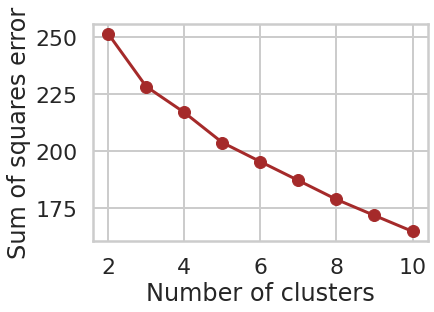

In [12]:
inertias = []

for k in range(2,11):
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, random_state=42).fit(x_cols)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(range(2,11), inertias, '-o', color='brown')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squares error')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


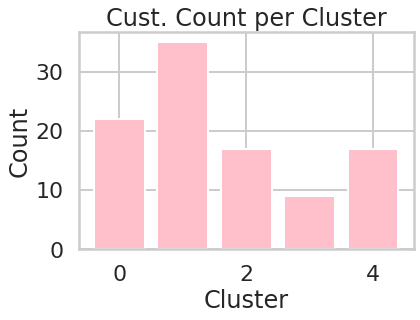

In [13]:
kmeans_cluster = KMeans(n_clusters = 5, random_state=42).fit(x_cols)

counts = [0 for i in range(5)]
for i in range(5):
    for label in kmeans_cluster.labels_:
        if label == i:
            counts[i] += 1

plt.bar(range(5), counts, color='pink')
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Cust. Count per Cluster")
plt.show()

Automatically created module for IPython interactive environment
For n_clusters = 2 The average silhouette_score is : 0.09174871508750351


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


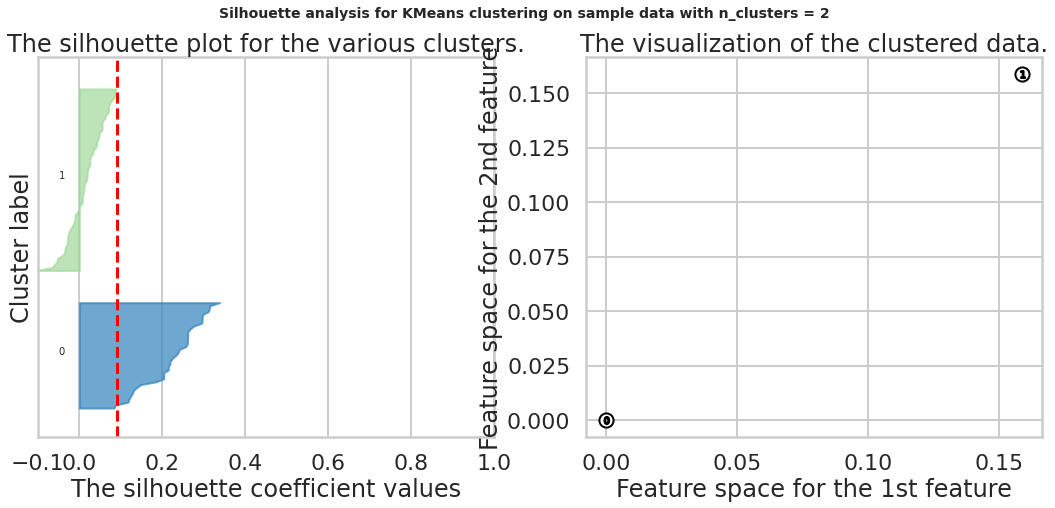

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 3 The average silhouette_score is : 0.11542407037894219


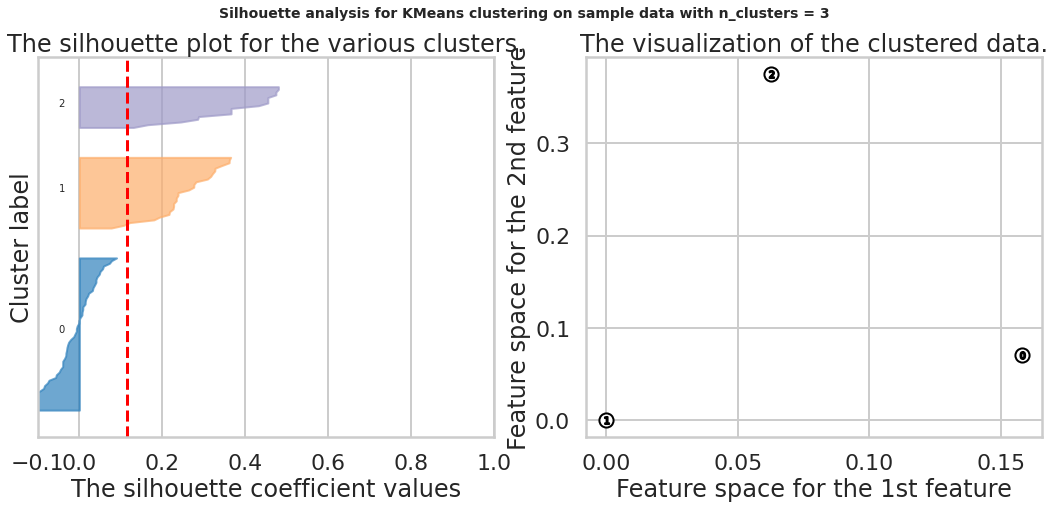

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 4 The average silhouette_score is : 0.09670258360693122


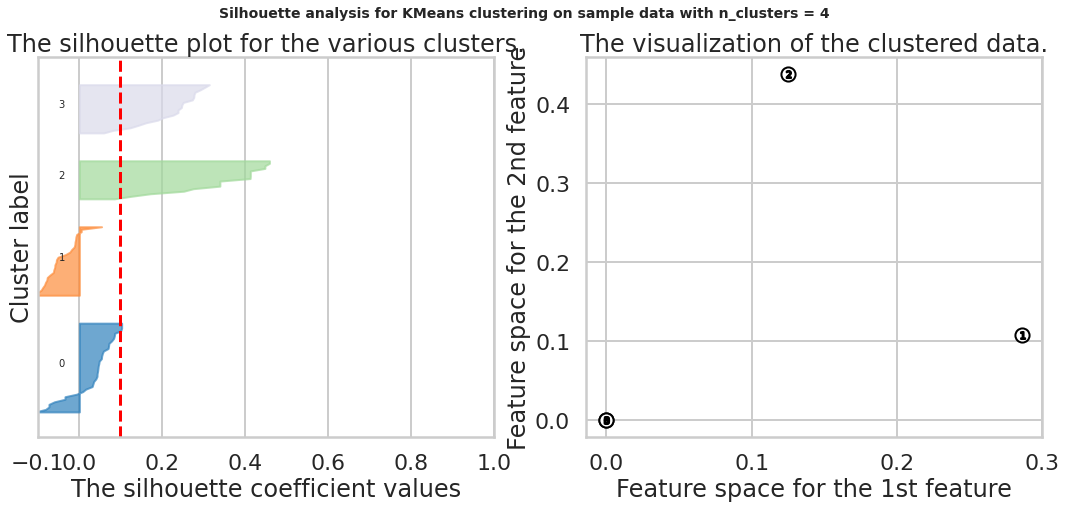

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 5 The average silhouette_score is : 0.14531568820332333


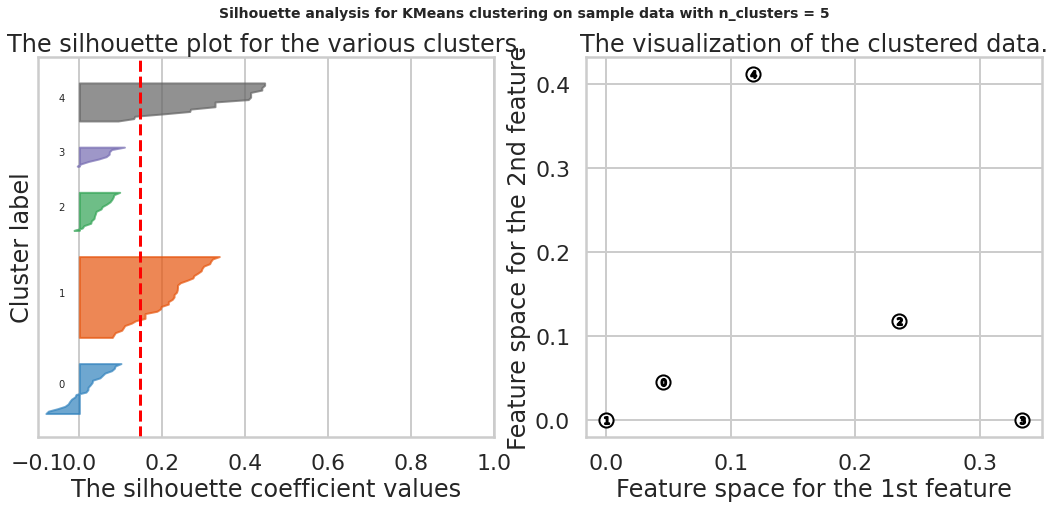

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 6 The average silhouette_score is : 0.13313126627114877


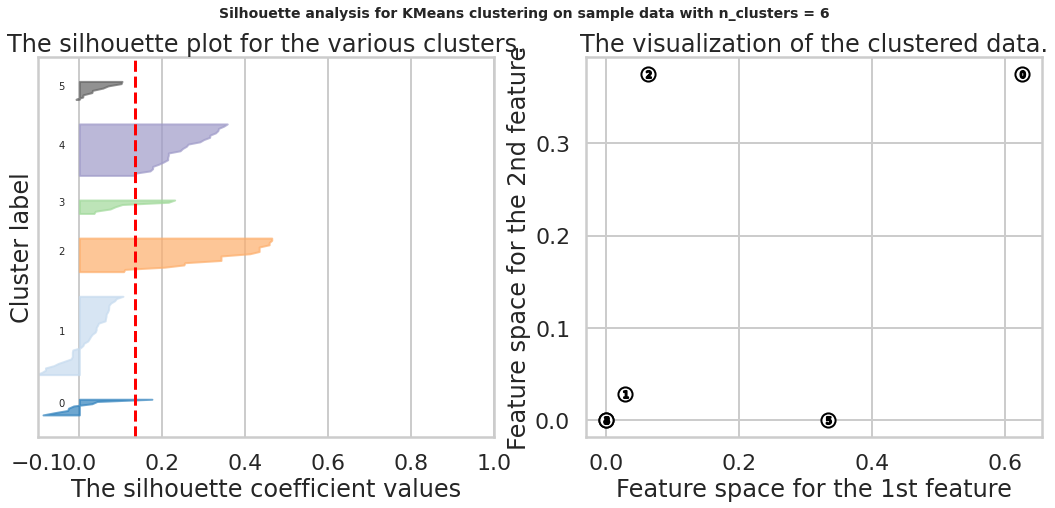

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 7 The average silhouette_score is : 0.13073950771832585


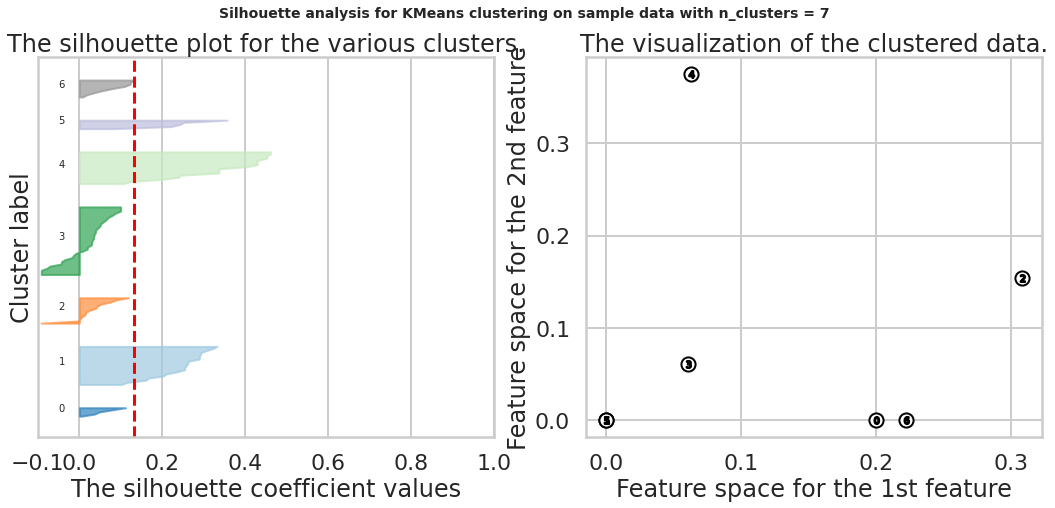

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 8 The average silhouette_score is : 0.12397572901124844


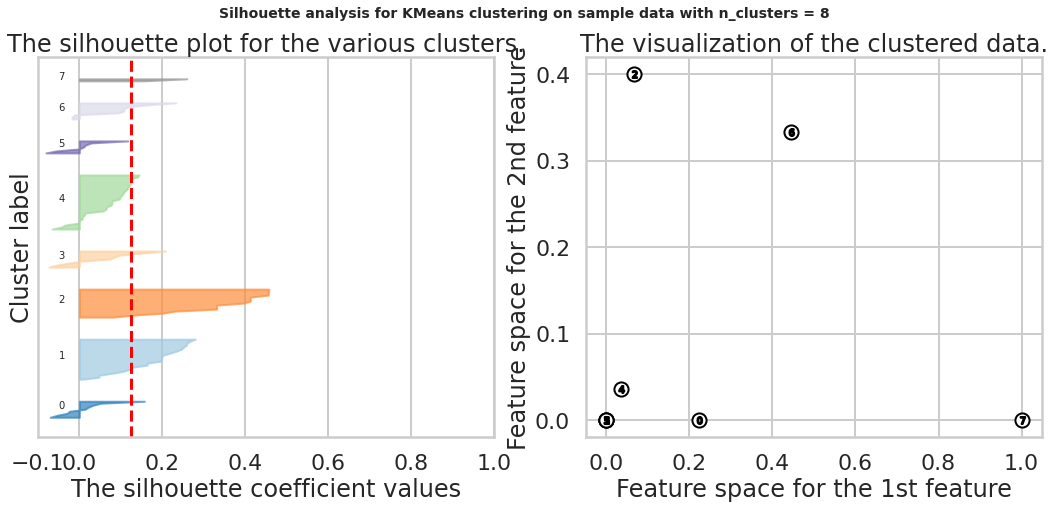

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 9 The average silhouette_score is : 0.1202465110942483


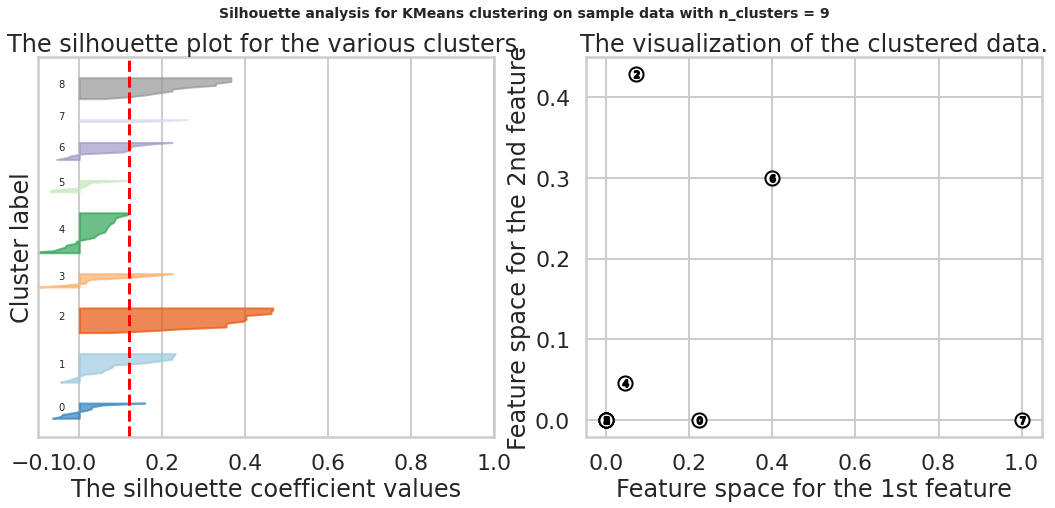

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


For n_clusters = 10 The average silhouette_score is : 0.12695143123424532


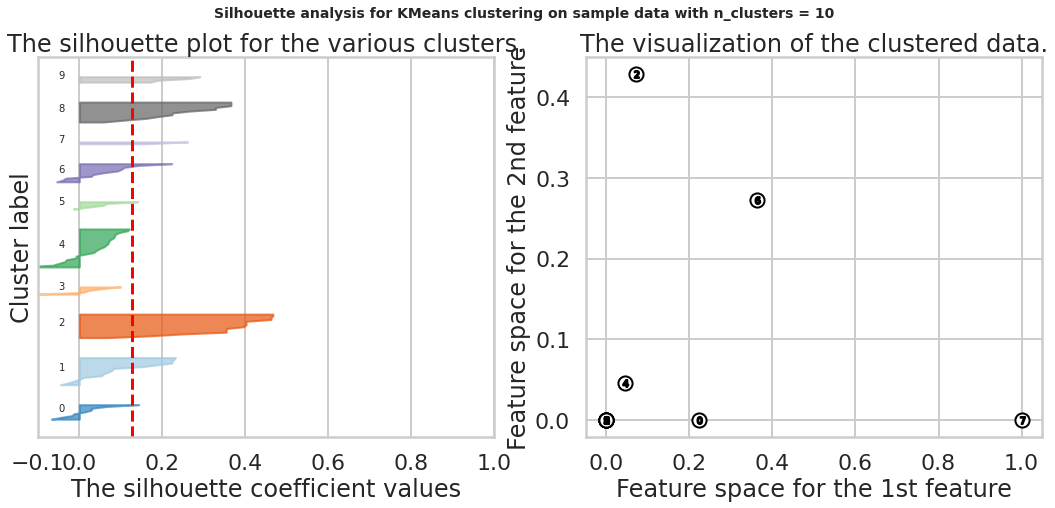

In [14]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

print(__doc__)

range_n_clusters = [i for i in range(2,11)]
silhouette_avgs = []

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_cols) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(x_cols)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_cols, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    silhouette_scores = silhouette_samples(x_cols, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            silhouette_scores[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.tab20c(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.tab20c(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(x_cols[:, 0], x_cols[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

In [15]:
from sklearn.decomposition import PCA

pca = pd.DataFrame(PCA(n_components=2).fit_transform(x_cols))
pca.columns = ['x','y']
pca['cluster'] = pd.Series(KMeans(n_clusters=5).fit(x_cols).labels_)
pca['customer_name'] = df.customer_name

pca.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


,x,y,cluster,customer_name
0,1.007580,0.108215,1,Adams
1,-0.287539,0.044715,2,Allen
2,-0.392032,1.038391,3,Anderson
3,0.699477,-0.022542,1,Bailey
4,0.088183,-0.471695,1,Baker


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


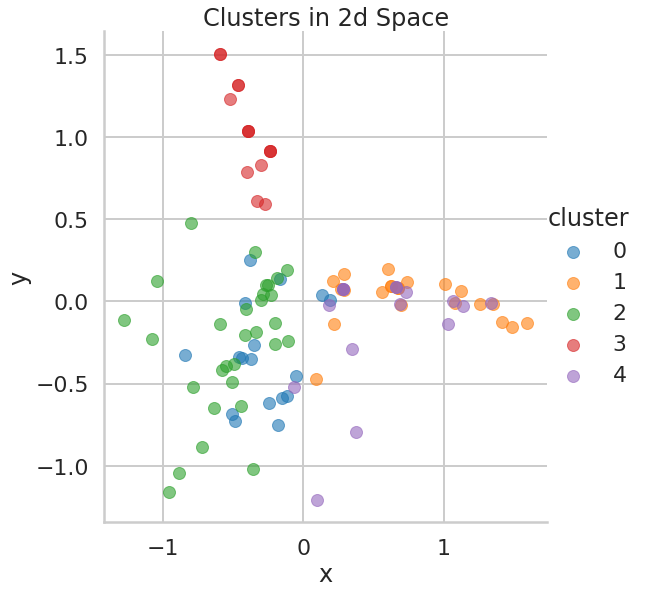

In [16]:
sns.lmplot('x','y', data = pca, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('Clusters in 2d Space')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seab

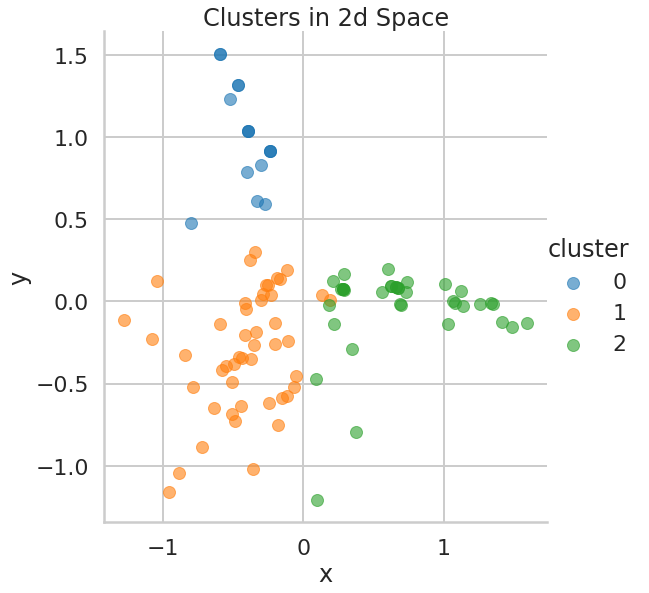

In [17]:
pca = pd.DataFrame(PCA(n_components=2).fit_transform(x_cols))
pca.columns = ['x','y']
pca['cluster'] = pd.Series(KMeans(n_clusters=3).fit(x_cols).labels_)
pca['customer_name'] = df.customer_name

sns.lmplot('x','y', data = pca, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('Clusters in 2d Space')
plt.show()

A cluster value of 3 would seem to be the best value, as the clusters are more distinct, evenly shaped, and have hardly any overlap

In [18]:
#Now look at both the original raw data about the offers and transactions and look at the fitted clusters. 
#Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?

#Merge datasets with cluster labels for exploring customer differences by group

o_and_c = pd.merge_ordered(df_offers, df_transactions, how='outer', on='offer_id')
o_and_c.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n
0,1,January,Malbec,72,56,France,False,Thomas,1
1,1,January,Malbec,72,56,France,False,Jackson,1
2,1,January,Malbec,72,56,France,False,Mitchell,1
3,1,January,Malbec,72,56,France,False,Peterson,1
4,1,January,Malbec,72,56,France,False,Wood,1


In [19]:
df_new = pd.merge_ordered(o_and_c, pca, how='outer', on='customer_name')
df_new.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak,customer_name,n,x,y,cluster
0,18,July,Espumante,6,50,Oregon,False,Adams,1,1.007580,0.108215,2
1,29,November,Pinot Grigio,6,87,France,False,Adams,1,1.007580,0.108215,2
2,30,December,Malbec,6,54,France,False,Adams,1,1.007580,0.108215,2
3,9,April,Chardonnay,144,57,Chile,False,Allen,1,-0.287539,0.044715,1
4,27,October,Champagne,72,88,New Zealand,False,Allen,1,-0.287539,0.044715,1


In [20]:
#what are the things that people have preferences for around wine? Red/white and country of origin. Let's account for these.
#add new column IDing red wines
red_dict = {'Champagne':0, 'Pinot Noir':1, 'Prosecco':0, 'Espumante':0, 'Cabernet Sauvignon':1, 'Malbec':1, 'Merlot':1, 'Pinot Grigio':0, 'Chardonnay':0}
df_new['is_red'] = df_new['varietal']
df_new.replace({'is_red':red_dict}, inplace=True)

#add new column: continent
continent_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':0, 'Germany':0, 'California':3, 'New Zealand':1}
df_new['continent'] = df_new['origin']
df_new.replace({'continent':continent_dict}, inplace=True)

In [21]:
#and group by their clusters
df_new.groupby(['cluster']).varietal.value_counts()
df_new.groupby('cluster').campaign.value_counts()
df_new.groupby('cluster').origin.value_counts()
df_new.groupby('cluster').is_red.value_counts()
df_new.groupby('cluster').continent.value_counts()
df_new.groupby("cluster")[['is_red','min_qty', 'discount', 'past_peak']].mean()

,is_red,min_qty,discount,past_peak
cluster,,,,
0,0.906977,65.581395,52.116279,0.000000
1,0.377143,81.634286,63.520000,0.205714
2,0.216981,17.150943,55.801887,0.198113


Cluster 3 vastly prefers reds, while Cluster 2 seems to go for buying in bulk. All groups appear to enjoy a discount, with Cluster 2 enjoying it a bit more, perhaps the joy of getting a discount on a bulk purchase. What greater spirit-lifter than a bargain? No one likes wine past its peak, especially red drinkers.

In [22]:
#Let's visualize, shall we? First we'll have to convert some columns to numerical. 
campaign_dict = {'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6, 'July':7, 'August':8, 'September':9,'October':10, 'November':11, 'December':12}
df_new.replace({'campaign':campaign_dict}, inplace=True)

#convert ['varietal'] to numerical
df_new['varietal'].value_counts()
varietal_dict = {'Champagne':1, 'Pinot Noir':2, 'Prosecco':3, 'Espumante':4, 'Cabernet Sauvignon':5, 'Malbec':6, 'Merlot':7, 'Pinot Grigio':8, 'Chardonnay':9}
df_new.replace({'varietal':varietal_dict}, inplace=True)

#convert ['origin'] to numerical
df_new['origin'].value_counts()
origin_dict = {'France':0, 'Australia':1, 'Chile':2, 'Oregon':3, 'South Africa':4, 'Italy':5, 'Germany':6, 'California':7, 'New Zealand':8}
df_new.replace({'origin':origin_dict}, inplace=True)

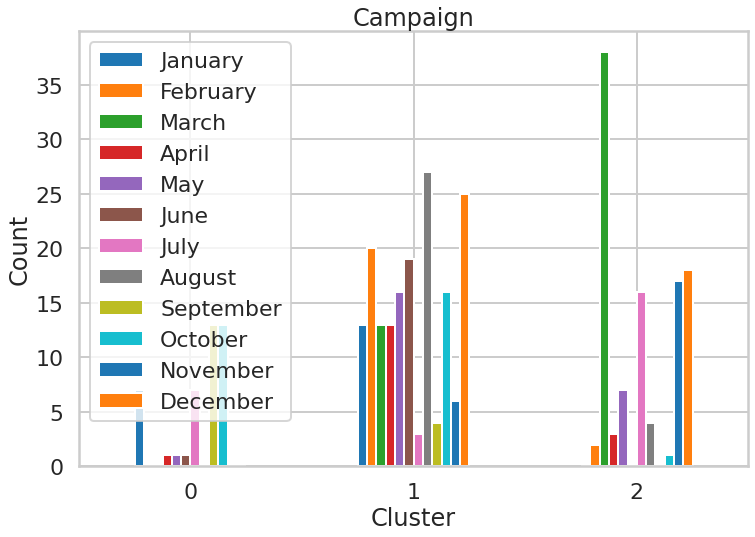

In [23]:
#which monthly campaigns were most successful with each cluster?
_ = pd.crosstab(df_new['cluster'], df_new['campaign']).plot(kind='bar', figsize=(12,8))
_ = plt.title('Campaign')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November','December'])

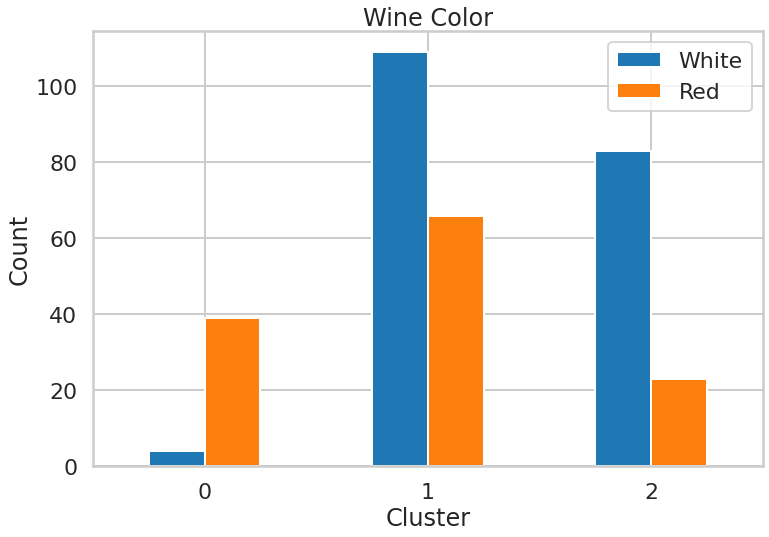

In [24]:
#how does white wine perform against red?
_ = pd.crosstab(df_new['cluster'], df_new['is_red']).plot(kind='bar', figsize=(12,8))
_ = plt.title('Wine Color')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['White', 'Red'])

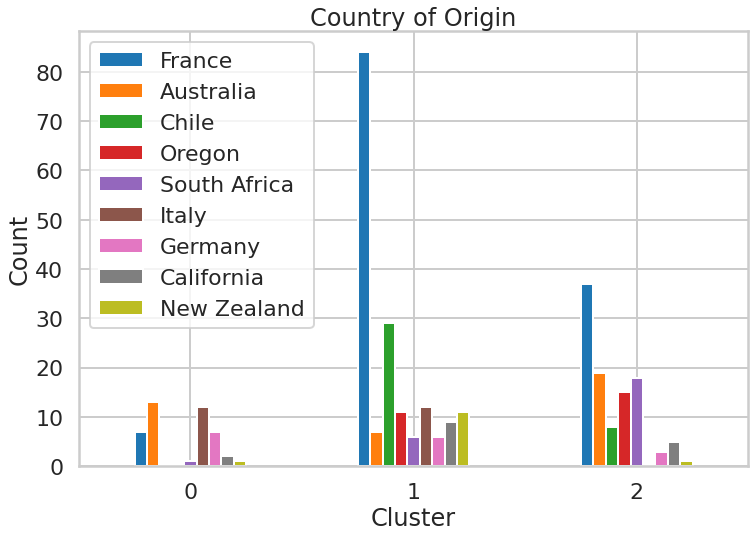

In [25]:
#which countries of origin are the most popular?
_ = pd.crosstab(df_new['cluster'], df_new['origin']).plot(kind='bar', figsize=(12,8))
_ = plt.title('Country of Origin')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['France', 'Australia', 'Chile', 'Oregon', 'South Africa', 'Italy', 'Germany', 'California', 'New Zealand'])

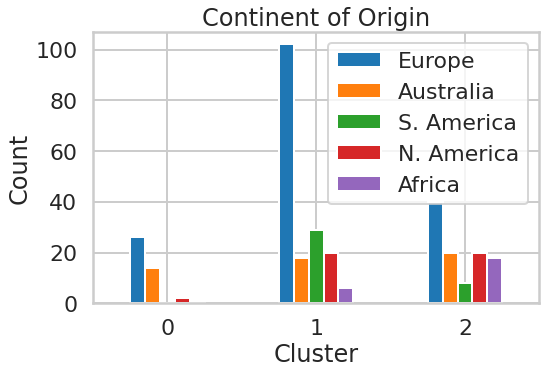

In [26]:
#which continents are the most popular?
_ = pd.crosstab(df_new['cluster'], df_new['continent']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Continent of Origin')
_ = plt.xlabel('Cluster')
_ = plt.xticks(range(0,3), ('0', '1', '2'), rotation=0) 
_ = plt.ylabel('Count')
_ = plt.legend(['Europe', 'Australia', 'S. America', 'N. America', 'Africa'])

We can clearly see that white wine beats red, and European wines (from France in particular) smoke the competition pretty handily, although South American wines look to be fairly popular with Cluster 2.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Text(0, 0.5, 'Explained Variance')

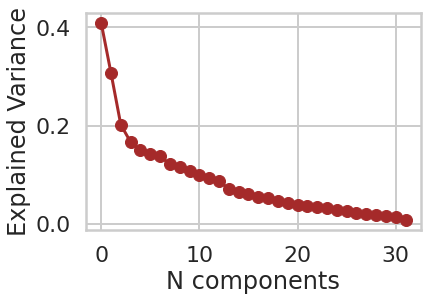

In [27]:
# Initialize a new PCA model with a default number of components.
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit(x_cols)

# Do the rest on your own :)

plt.plot(pca.explained_variance_, '-o', color='brown')
plt.axis('tight')
plt.xlabel('N components')
plt.ylabel('Explained Variance')

In [28]:
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN
from sklearn import metrics

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seab

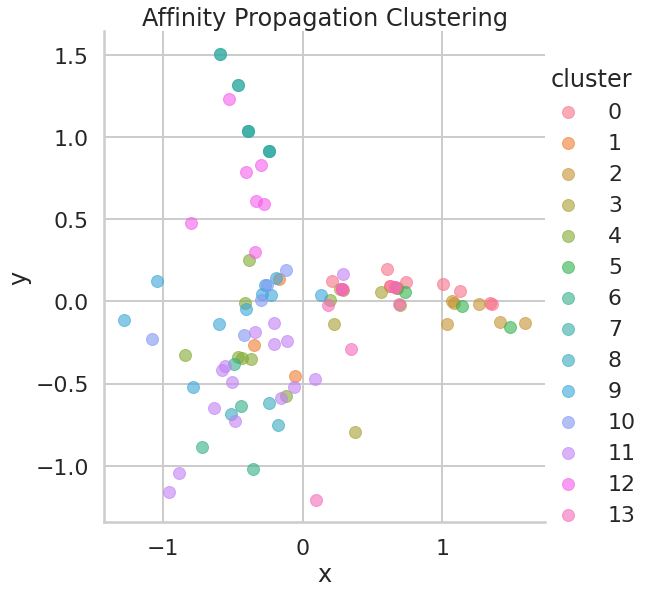

In [29]:
#Affinity propagation

decomposer = PCA(n_components=2)
X_reduced = decomposer.fit_transform(x_cols)
label = AffinityPropagation().fit_predict(x_cols)
affinity_clusters = pd.DataFrame({"x":X_reduced[:,0], "y":X_reduced[:,1], "cluster":label}, index=df.index)

sns.lmplot('x','y', data = affinity_clusters, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('Affinity Propagation Clustering')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


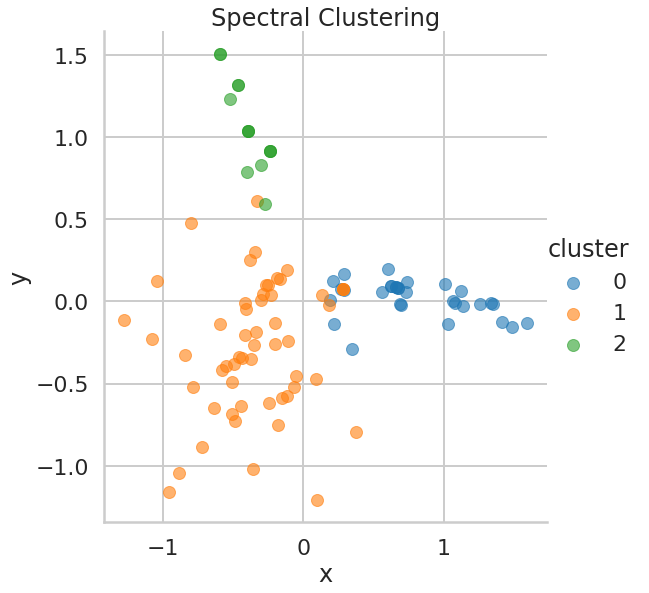

In [30]:
#Spectral Clustering 
label = SpectralClustering(n_clusters=3).fit_predict(x_cols)

spectral_clusters = pd.DataFrame({"x":X_reduced[:,0], "y":X_reduced[:,1], "cluster":label}, index=df.index)

sns.lmplot('x','y', data = spectral_clusters, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('Spectral Clustering')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


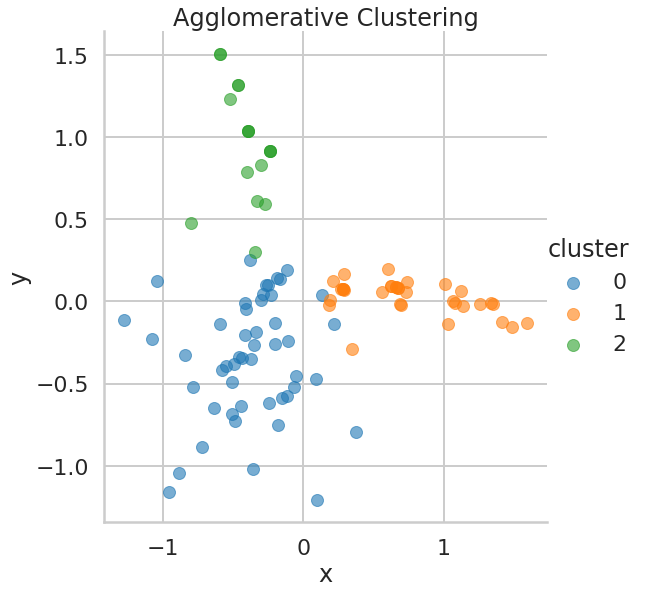

In [31]:
#Agglomerative clustering
label = AgglomerativeClustering(n_clusters=3).fit_predict(x_cols)

agg_clusters = pd.DataFrame({"x":X_reduced[:,0], "y":X_reduced[:,1], "cluster":label}, index=df.index)

sns.lmplot('x','y', data = agg_clusters, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('Agglomerative Clustering')
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


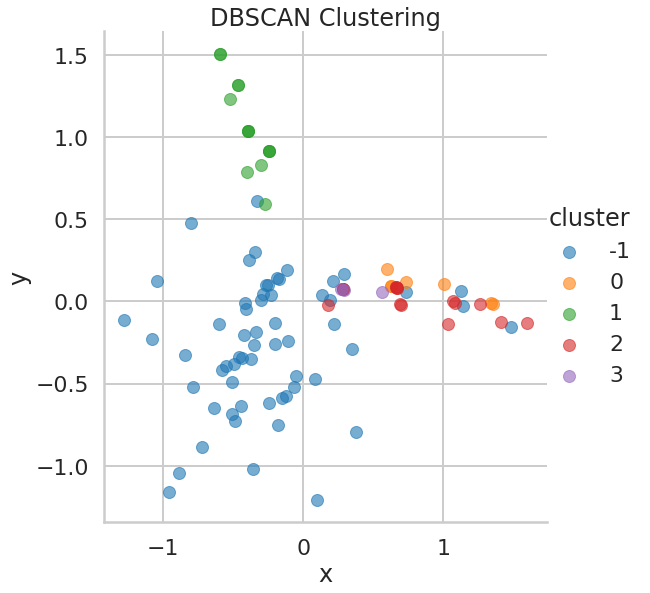

In [32]:
#DBSCAN 
label = DBSCAN(eps=1).fit_predict(x_cols)

dbscan_clusters = pd.DataFrame({"x":X_reduced[:,0], "y":X_reduced[:,1], "cluster":label}, index=df.index)

sns.lmplot('x','y', data = dbscan_clusters, hue = 'cluster', fit_reg=False, size = 8, scatter_kws={'alpha':.6})
plt.title('DBSCAN Clustering')
plt.show()

Affinity propagation was all over the place with far too many clusters, while DBSCAN found one cluster and a whole bunch of noise. Spectral clustering and agglomerative clustering were able to produce similar results to the K-means. However, the decision boundaries generated by these algorithms seemed more ambiguous.